# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План проекта
1. Исследовательский анализ и предобработка данных
    - Вывод информации по каждому датасету;
    - Изменение типа данных;
    - Замена пропусков;
    - Исключение партий, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему;
    - Добавление новых признаков;
    - Выявление аномальных значений;
    - Объединение таблиц;
    - Проверка признаков на мультиколлинеарность.
1. Построение модели, которая предскажет температуру стали:
    - Формирование выборок: обучающая, валидационная и тестовая;
    - Масштабирование признаков;
    - Обучение моделей и проверка их на эффективность с помощью показателя эффективности МАЕ;
    - Визуализация важности признаков при обучении;
    - Выбор лучшей модели для поставленной задачи.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore') 


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

## Анализ и предобработка данных

In [3]:
def showing(data):
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество пропусков:', data.isnull().sum())
    display(data.head(5))
    display(data.tail(5))
    print(data.info())
    print(data.describe())
    print()
    print('Количество итераций')
    plt.hist((list(data['key'].value_counts())), bins=10);

### Данные об электродах

Количество дубликатов: 0
Количество пропусков: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034        

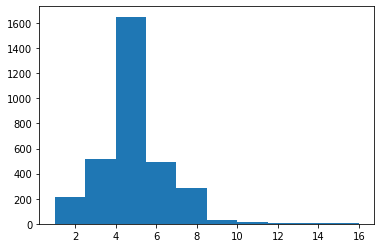

In [4]:
showing(arc)

Фрейм с данными об электродах даёт представление о 3241 партии c количеством итераций от 1 до 16, не имеет полных дубликатов и пропусков, зато хранит дату и время в несоответствующем формате и отрицательные значения реактивной мощности.

In [5]:
arc[arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [6]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
arc = arc[arc['Реактивная мощность'] > 0]

Добавим признаки. Полную мощность вычислим по формуле:
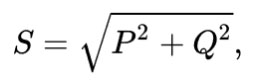
где:  
    *S - полная мощность, ВА;  
     P - активная мощность, Вт;  
     Q - реактивная мощность, ВАр.*

In [7]:
arc['heating_time_sec'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.seconds
arc['full_power'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_time_sec,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280,1.256527


In [8]:
arc.corr()

,key,Активная мощность,Реактивная мощность,heating_time_sec,full_power
key,1.000000,-0.021367,-0.000159,-0.018341,-0.013292
Активная мощность,-0.021367,1.000000,0.963182,0.974129,0.994279
Реактивная мощность,-0.000159,0.963182,1.000000,0.971269,0.986237
heating_time_sec,-0.018341,0.974129,0.971269,1.000000,0.981205
full_power,-0.013292,0.994279,0.986237,0.981205,1.000000


При проверке на мультиколлинеарность видим сильную зависимость признаков: активная, реактивная мощность, время нагрева и полная мощность.

Их высокая корреляция может привести к переобучению моделей, поэтому от данных об активной и реактивной мощности можно избавиться.

In [9]:
arc_count = arc['key'].value_counts().sort_index().reset_index()
arc_count = arc_count.rename(columns={'index': 'key',
                          'key': 'arc_count'})
arc = arc.groupby(by = 'key', as_index=False).sum()
arc = arc.merge(arc_count, how='left', on='key')
arc = arc.drop(['Активная мощность', 'Реактивная мощность', 'arc_count'], axis=1)
arc.head()

,key,heating_time_sec,full_power
0,1,1098,5.826395
1,2,811,3.649216
2,3,655,2.989534
3,4,741,3.814962
4,5,869,4.035758


### Данные о подаче сыпучих материалов (объём)

Количество дубликатов: 0
Количество пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   

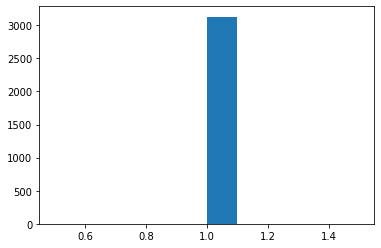

In [10]:
showing(bulk)

В данных о подаче сыпучих материалов нет дубликатов, имеется множество пропусков, обусловленных спецификой технологического процесса (значит на месте пропусков - отсутствие добавления, можно заменить на 0).

In [11]:
bulk = bulk.fillna(0)
bulk['sum_bulk'] = bulk.iloc[:, 1:16].sum(axis=1)

In [12]:
bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,232.0


### Данные о подаче сыпучих материалов (время)

Количество дубликатов: 0
Количество пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.00000

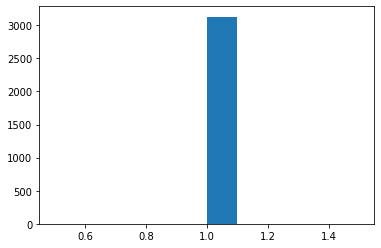

In [13]:
showing(bulk_time)

Для дальнейшего анализа и построения модели данные о времени подачи сыпучих материалов нам не пригодятся, менять тип данных и обрабатывать пропуски не будем.

### Данные о продувке сплава газом

Количество дубликатов: 0
Количество пропусков: key      0
Газ 1    0
dtype: int64


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Количество итераций


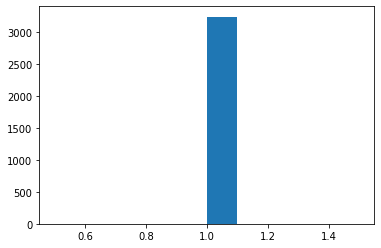

In [14]:
showing(gas)

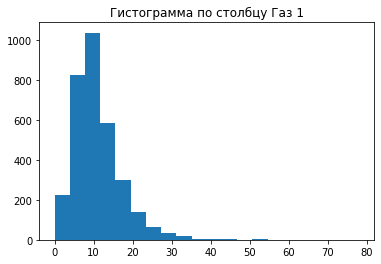

In [15]:
plt.hist((list(gas['Газ 1'])), bins=20)
plt.title('Гистограмма по столбцу Газ 1');

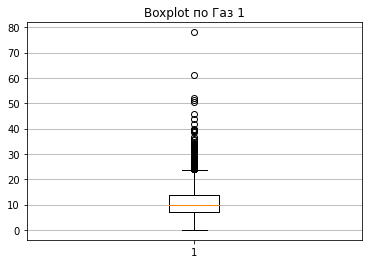

In [16]:
plt.boxplot(gas['Газ 1'])
plt.grid(axis='y')
plt.title('Boxplot по Газ 1');

In [17]:
gas = gas.rename(columns={'Газ 1':'gas'})

### Pезультаты измерения температуры

Количество дубликатов: 0
Количество пропусков: key                0
Время замера       0
Температура     2901
dtype: int64


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Количество итераций


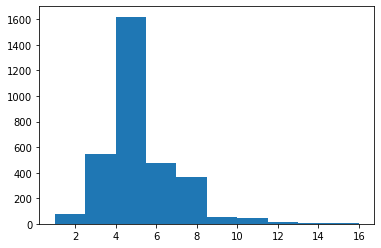

In [18]:
showing(temp)

Видим, что на каждую партию приходится несколько температурных замеров (количество итераций), но в некоторых партиях замеры отсутствуют. Так же изменим тип даты и посмотрим на аномальные значения температур. Добавим признаки с температурой первого и последнего замера для каждой партии.

In [19]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format = '%Y-%m-%d %H:%M:%S')

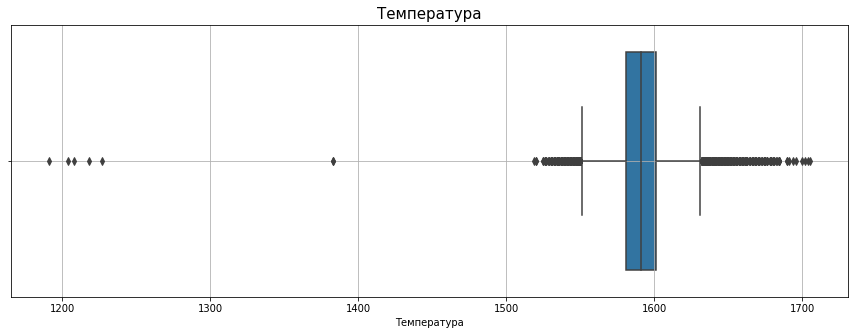

In [20]:
plt.figure(figsize=(15,5))
sns.boxplot(temp['Температура'])
plt.title('Температура', fontsize=15)
plt.grid(True)

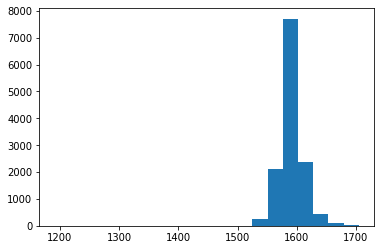

In [21]:
plt.hist((list(temp['Температура'])), bins=20);

In [22]:
#temp = temp.sort_values(by=['key', 'Время замера'], ascending=True).pivot_table(values=['Время замера', 'Температура'],
#                                                   index='key',
#                                                   aggfunc={'Время замера': ['first', 'last']
#                                                          'Температура': ['first', 'last']})
        

temp = temp.fillna(0)  # заменили пропуски на 0, чтобы после группировки данные с пропусками не потерялись
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.tail()

key        Время замера                     Температура     
                         first                last       first last
3211  3237 2019-08-31 22:44:04 2019-08-31 23:05:43      1569.0  0.0
3212  3238 2019-08-31 23:30:31 2019-08-31 23:43:00      1584.0  0.0
3213  3239 2019-09-01 01:31:47 2019-09-01 02:24:15      1598.0  0.0
3214  3240 2019-09-01 02:39:01 2019-09-01 03:35:16      1617.0  0.0
3215  3241 2019-09-01 04:03:30 2019-09-01 04:38:08      1586.0  0.0

In [23]:
temp.columns = ['key', 'Замер 1', 'Замер 2', 'temp_start', 'temp_finish']

temp = temp.drop(['Замер 1', 'Замер 2'], axis = 1)
temp.tail()

temp = temp[temp['temp_finish'] != 0]  # удалили партии, где нет последних замеров (0 вместо NaN)
temp = temp[temp['temp_finish'] != temp['temp_start']]  # и партии, где первое измерение=последнему(т.е. производился только один замер)
temp.tail()

,key,temp_start,temp_finish
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0
2476,2499,1569.0,1603.0


### Данные о проволочных материалах (объём)

Количество дубликатов: 0
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15

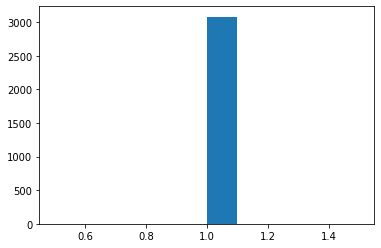

In [24]:
showing(wire)

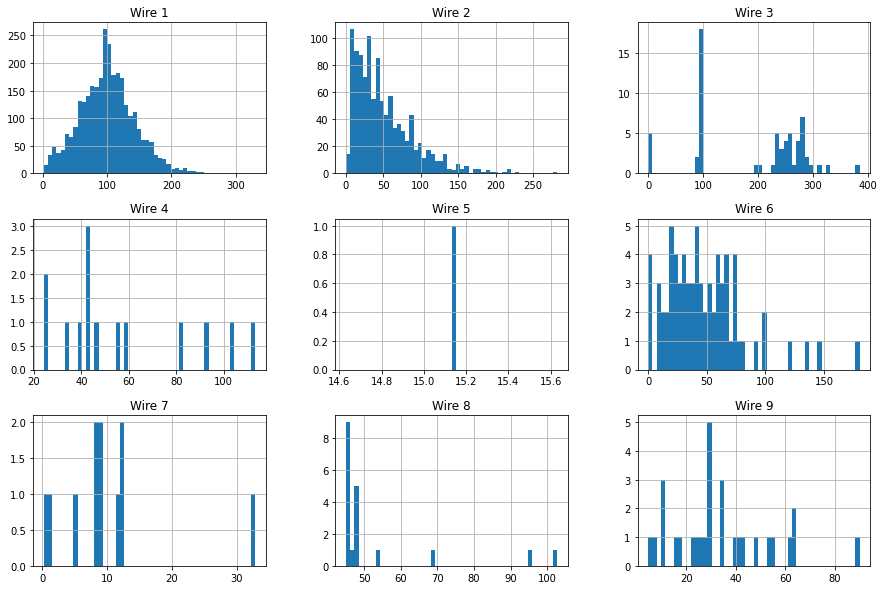

In [25]:
wire.iloc[:, 1:10].hist(bins=50, figsize=(15,10));

В данных о добавлении проволочных материалов так же имеются пропуски, что говорит о том, что какие-то материалы в легировании не применялись, пропуски заменим на 0 и посчитаем сумму, т.к. видим, что в изменении состава сплава учавствует по большей части лишь материал Wire 1.

In [26]:
wire = wire.fillna(0)
wire['sum_wire'] = wire.iloc[:, 1:10].sum(axis=1)

### Данные о проволочных материалах (время)

Количество дубликатов: 0
Количество пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Количество итераций


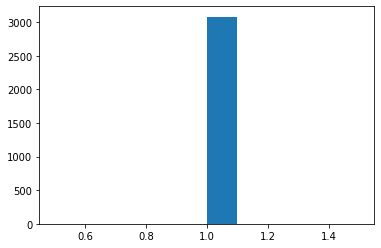

In [27]:
showing(wire_time)

Данные о времени легирования проволочными материалами нам не пригодитятся.

### Объединение данных

In [28]:
df = (arc.merge(temp, how='left', on='key')
         .merge(wire, how='left', on='key')
         .merge(bulk, how='left', on='key')
         .merge(gas, how='left', on='key'))
df

,key,heating_time_sec,full_power,temp_start,temp_finish,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
0,1,1098,5.826395,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,811,3.649216,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,655,2.989534,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,741,3.814962,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,869,4.035758,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,909,4.844982,NaN,NaN,38.088959,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,5.543905
3210,3238,546,2.696542,NaN,NaN,56.128799,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,6.745669
3211,3239,1216,5.611883,NaN,NaN,143.357761,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,16.023518
3212,3240,839,3.891856,NaN,NaN,34.070400,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0,11.863103


In [29]:
df.corr()

,key,heating_time_sec,full_power,temp_start,temp_finish,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
key,1.000000,-0.045207,-0.036823,-0.019455,-0.084517,-0.070682,0.014688,0.008848,0.016953,0.018224,...,0.003089,-0.020783,0.026706,0.024932,-0.016531,-0.006789,-0.088532,-0.050075,-0.054288,-0.044471
heating_time_sec,-0.045207,1.000000,0.983356,-0.299192,0.208250,0.074210,0.041731,0.026730,0.050705,0.024532,...,-0.009824,0.013304,-0.012169,0.076789,0.453993,0.113879,0.422781,0.267759,0.531948,0.391564
full_power,-0.036823,0.983356,1.000000,-0.326534,0.222397,0.059334,0.043932,0.029948,0.053565,0.022499,...,-0.009082,0.021382,-0.006902,0.070913,0.466943,0.105129,0.413814,0.291862,0.537266,0.359499
temp_start,-0.019455,-0.299192,-0.326534,1.000000,0.371569,0.208995,-0.079950,-0.000424,0.064483,NaN,...,-0.009659,-0.027616,0.025387,-0.090995,-0.047375,0.015361,-0.129851,-0.093853,-0.102818,-0.001093
temp_finish,-0.084517,0.208250,0.222397,0.371569,1.000000,0.314117,-0.206544,-0.047055,-0.159740,NaN,...,-0.021887,-0.019194,0.021197,-0.100064,0.221210,-0.015708,0.065035,0.052996,0.087956,-0.034821
Wire 1,-0.070682,0.074210,0.059334,0.208995,0.314117,1.000000,-0.047830,0.063817,-0.132208,-0.034386,...,0.031886,0.029969,0.063759,-0.114341,0.179672,0.053679,-0.042533,0.130589,0.114523,0.124520
Wire 2,0.014688,0.041731,0.043932,-0.079950,-0.206544,-0.047830,1.000000,0.143654,-0.032147,-0.009527,...,0.016794,0.060512,-0.100735,0.052391,-0.107726,-0.002054,0.069471,-0.093838,-0.057931,0.093465
Wire 3,0.008848,0.026730,0.029948,-0.000424,-0.047055,0.063817,0.143654,1.000000,0.150632,0.054946,...,-0.002347,-0.009888,-0.030545,-0.025148,-0.125475,-0.009694,0.014136,-0.119583,-0.079685,0.113819
Wire 4,0.016953,0.050705,0.053565,0.064483,-0.159740,-0.132208,-0.032147,0.150632,1.000000,-0.001096,...,-0.001116,-0.004702,-0.014524,-0.011960,-0.081995,-0.004609,-0.116228,-0.087404,0.037373,0.137948
Wire 5,0.018224,0.024532,0.022499,NaN,NaN,-0.034386,-0.009527,0.054946,-0.001096,1.000000,...,-0.000331,-0.001393,-0.004304,-0.003545,-0.024300,-0.001366,-0.034445,-0.025903,0.010628,0.081581


Количество дубликатов: 0
Количество пропусков: key                   0
heating_time_sec      0
full_power            0
temp_start          781
temp_finish         781
Wire 1              134
Wire 2              134
Wire 3              134
Wire 4              134
Wire 5              134
Wire 6              134
Wire 7              134
Wire 8              134
Wire 9              134
sum_wire            134
Bulk 1               86
Bulk 2               86
Bulk 3               86
Bulk 4               86
Bulk 5               86
Bulk 6               86
Bulk 7               86
Bulk 8               86
Bulk 9               86
Bulk 10              86
Bulk 11              86
Bulk 12              86
Bulk 13              86
Bulk 14              86
Bulk 15              86
sum_bulk             86
gas                   2
dtype: int64


,key,heating_time_sec,full_power,temp_start,temp_finish,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
0,1,1098,5.826395,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,811,3.649216,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,655,2.989534,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,741,3.814962,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,869,4.035758,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692


,key,heating_time_sec,full_power,temp_start,temp_finish,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
3209,3237,909,4.844982,NaN,NaN,38.088959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,5.543905
3210,3238,546,2.696542,NaN,NaN,56.128799,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,6.745669
3211,3239,1216,5.611883,NaN,NaN,143.357761,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,16.023518
3212,3240,839,3.891856,NaN,NaN,34.070400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0,11.863103
3213,3241,659,2.999516,NaN,NaN,63.117595,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,232.0,12.680959


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   heating_time_sec  3214 non-null   int64  
 2   full_power        3214 non-null   float64
 3   temp_start        2433 non-null   float64
 4   temp_finish       2433 non-null   float64
 5   Wire 1            3080 non-null   float64
 6   Wire 2            3080 non-null   float64
 7   Wire 3            3080 non-null   float64
 8   Wire 4            3080 non-null   float64
 9   Wire 5            3080 non-null   float64
 10  Wire 6            3080 non-null   float64
 11  Wire 7            3080 non-null   float64
 12  Wire 8            3080 non-null   float64
 13  Wire 9            3080 non-null   float64
 14  sum_wire          3080 non-null   float64
 15  Bulk 1            3128 non-null   float64
 16  Bulk 2            3128 non-null   float64


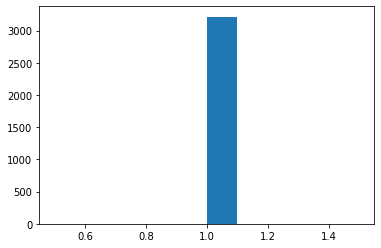

In [30]:
showing(df)

По новому датафрейму мы можем отслеживать процесс обработки стали. Появились пропуски в данных о подаче материалов и продувке газом, что может говорить о несоответствии технологическому процессу.

In [31]:
df = df.dropna()
display(df.isna().sum())

key                 0
heating_time_sec    0
full_power          0
temp_start          0
temp_finish         0
Wire 1              0
Wire 2              0
Wire 3              0
Wire 4              0
Wire 5              0
Wire 6              0
Wire 7              0
Wire 8              0
Wire 9              0
sum_wire            0
Bulk 1              0
Bulk 2              0
Bulk 3              0
Bulk 4              0
Bulk 5              0
Bulk 6              0
Bulk 7              0
Bulk 8              0
Bulk 9              0
Bulk 10             0
Bulk 11             0
Bulk 12             0
Bulk 13             0
Bulk 14             0
Bulk 15             0
sum_bulk            0
gas                 0
dtype: int64

Посмотрим на выбросы и избавимся от явных.

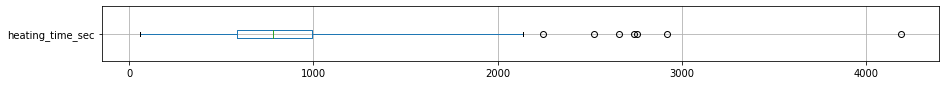

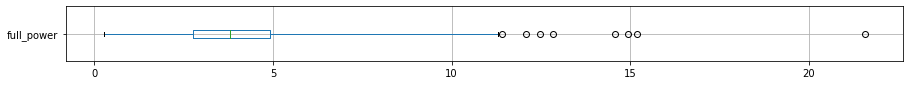

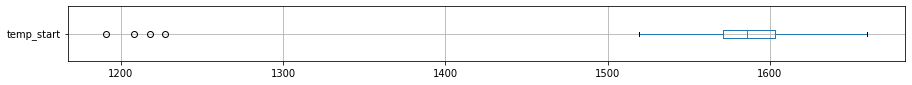

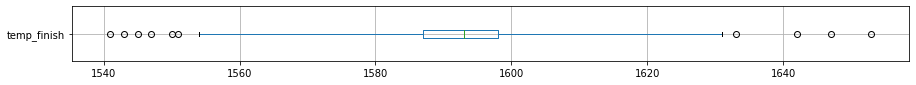

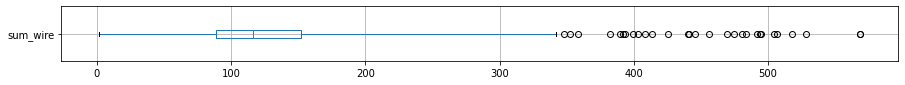

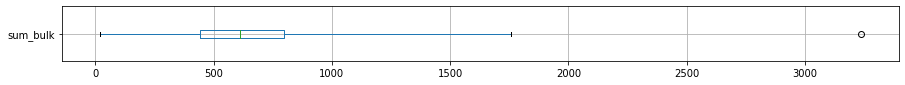

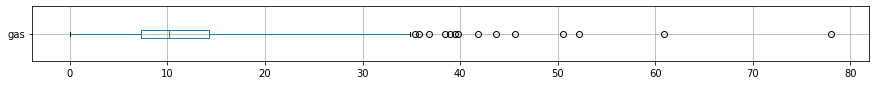

In [32]:
def emissions():
    x = ['heating_time_sec', 'full_power', 'temp_start', 'temp_finish', 
                         'sum_wire', 'sum_bulk', 'gas']

    for name in x:
        plt.figure(figsize=(15,1))
        df.boxplot(name, vert=False, whis=3)
        plt.show()
        
emissions()

In [33]:
df = (df.loc[(df['heating_time_sec'] < 2100) &
            (df['full_power'] < 11) &
            (df['temp_start'] > 1350) &  # температура плавления стали начинается с 1300°C до 1400°C, возьмём среднее
            (df['temp_finish'] < 1630) &
            (df['temp_finish'] > 1350) &
            (df['sum_wire'] < 335) &
            (df['sum_bulk'] < 1550) &
            (df['gas'] < 33)])

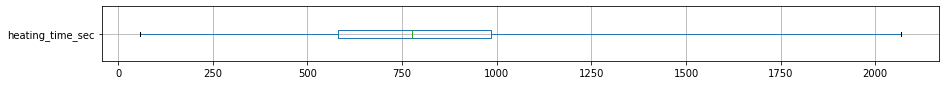

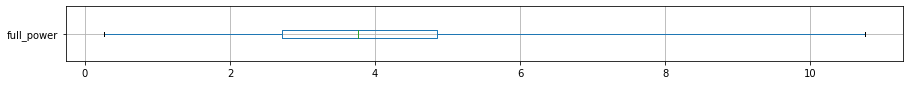

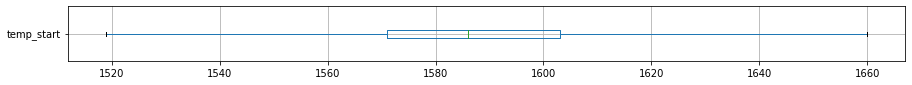

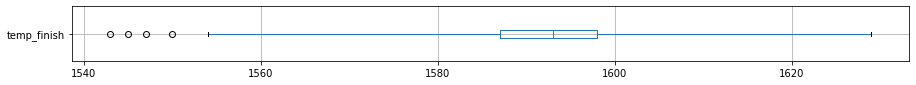

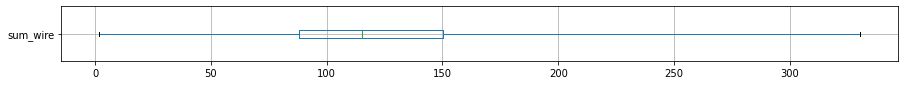

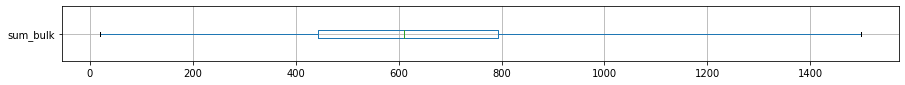

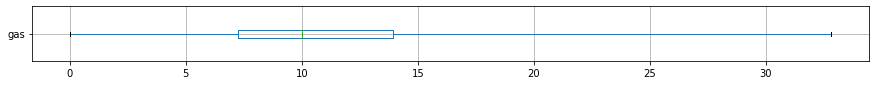

In [34]:
emissions()

In [35]:
df.corr()

,key,heating_time_sec,full_power,temp_start,temp_finish,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
key,1.000000,-0.021037,-0.006370,-0.028845,-0.093255,-0.025420,0.057460,0.023397,0.048849,NaN,...,0.015803,-0.029690,0.062858,0.034145,0.030845,-0.024676,-0.101508,-0.050020,-0.024674,-0.032133
heating_time_sec,-0.021037,1.000000,0.980457,-0.433336,0.284043,0.057602,0.045102,0.007536,0.009892,NaN,...,-0.011767,-0.000701,-0.004827,0.086281,0.474796,0.049033,0.447220,0.317833,0.546049,0.367026
full_power,-0.006370,0.980457,1.000000,-0.481777,0.279333,0.039483,0.044375,0.013504,0.013201,NaN,...,-0.010864,0.006467,0.001901,0.081265,0.486463,0.039065,0.443403,0.347130,0.559000,0.341639
temp_start,-0.028845,-0.433336,-0.481777,1.000000,0.298312,0.278266,-0.105590,0.091650,0.038699,NaN,...,-0.011908,-0.015980,0.038117,-0.113649,-0.097510,0.026023,-0.184636,-0.068793,-0.137048,0.015530
temp_finish,-0.093255,0.284043,0.279333,0.298312,1.000000,0.327583,-0.220778,-0.064610,-0.138608,NaN,...,-0.027902,-0.015587,0.068419,-0.111813,0.253525,-0.024265,0.089137,0.271488,0.215614,0.059595
Wire 1,-0.025420,0.057602,0.039483,0.278266,0.327583,1.000000,-0.103786,-0.129285,-0.121136,NaN,...,0.036555,0.016954,0.069336,-0.124187,0.187521,0.026404,-0.068083,0.126028,0.123655,0.136717
Wire 2,0.057460,0.045102,0.044375,-0.105590,-0.220778,-0.103786,1.000000,-0.029244,-0.028589,NaN,...,0.021070,0.056033,-0.104473,0.081022,-0.116515,0.006216,0.016969,-0.100459,-0.089048,0.086230
Wire 3,0.023397,0.007536,0.013504,0.091650,-0.064610,-0.129285,-0.029244,1.000000,0.725946,NaN,...,-0.001194,-0.003781,-0.013822,-0.010569,-0.077450,-0.004226,-0.108140,-0.080639,0.049668,0.098055
Wire 4,0.048849,0.009892,0.013201,0.038699,-0.138608,-0.121136,-0.028589,0.725946,1.000000,NaN,...,-0.001151,-0.003647,-0.013334,-0.010195,-0.074880,-0.004077,-0.104504,-0.077984,0.024301,0.071222
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы изучили данные и выполнили предобработку: удаление пропущенных значений, изменение типа данных, избавление от ненужных данных, введение новых признаков и удаление мультиколлинеарных, объединение датасетов в один, обработка аномалий и выбросов.  
Данные готовы к обучению модели.

## Обучение модели

***Формирование выборок***

In [36]:
features = df.drop(['temp_finish', 'key'], axis = 1)
target = df['temp_finish']

# Получение пропорции 60:40

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.4, random_state = 12345)

# Получение 20% валидационных данных

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size = 0.50, random_state = 12345)

In [37]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)
print()
print(target_train.shape)
print(target_test.shape)
print(target_valid.shape)

(1333, 30)
(445, 30)
(445, 30)

(1333,)
(445,)
(445,)


***Масштабирование признаков***

In [38]:
numeric = features.columns

scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Вычислим для сравнения константу - медианную среднюю абсолютную ошибку.

In [39]:
predicted_valid_for_median = pd.Series(target_train.median(), index=target_valid.index)
print('Медианная MAE', round(mae(target_valid, predicted_valid_for_median),4))

Медианная MAE 8.2674


### LinearRegression

In [40]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print('MAE  на валидационной выборке =', mae(target_valid, predictions_valid))
predictions_test = model.predict(features_test)
print('МАЕ на тестовой выборке =', mae(target_test, predictions_test))

MAE  на валидационной выборке = 6.105841046239971
МАЕ на тестовой выборке = 5.992325501010303
CPU times: user 43.3 ms, sys: 57.4 ms, total: 101 ms
Wall time: 76.4 ms


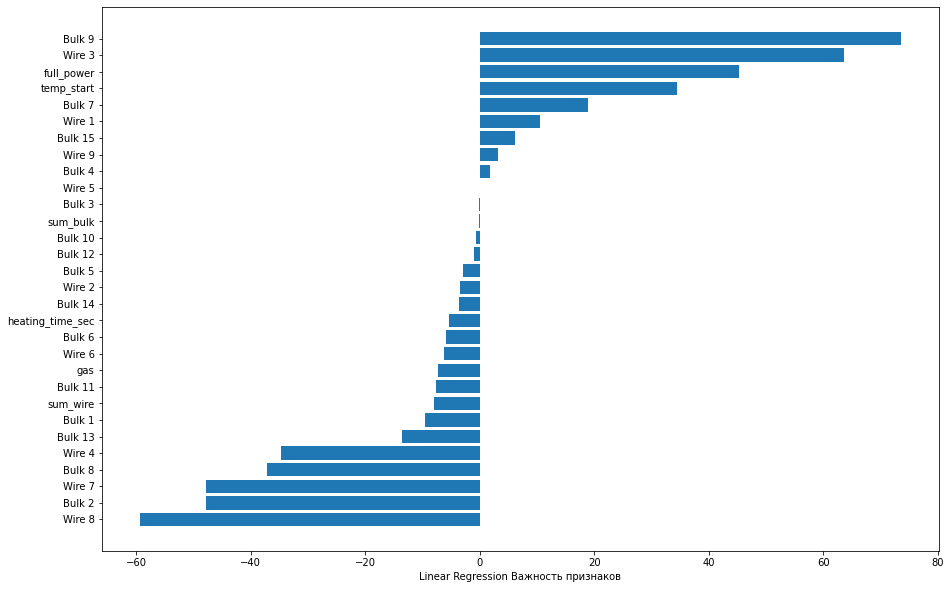

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model.coef_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model.coef_[sorted_idx])
plt.xlabel("Linear Regression Важность признаков");

### LogisticRegression

In [42]:
%%time

model_logistic = LogisticRegression()
model_logistic.fit(features_train, target_train)
predictions_valid = model_logistic.predict(features_valid)
predictions_test = model_logistic.predict(features_test)
print('MАЕ на валидационной выборке =', mae(target_valid, predictions_valid))
print('MАЕ на тестовой выборке =', mae(target_test, predictions_test))

MАЕ на валидационной выборке = 7.602247191011236
MАЕ на тестовой выборке = 7.274157303370787
CPU times: user 1.17 s, sys: 2.69 s, total: 3.87 s
Wall time: 3.84 s


Feature: 0, Score: 0.01490
Feature: 1, Score: -0.02025
Feature: 2, Score: 0.31866
Feature: 3, Score: -0.29940
Feature: 4, Score: -0.07257
Feature: 5, Score: 0.77720
Feature: 6, Score: 0.59222
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.56725
Feature: 9, Score: 0.88875
Feature: 10, Score: -0.00354
Feature: 11, Score: -0.00582
Feature: 12, Score: 0.43134
Feature: 13, Score: 0.22154
Feature: 14, Score: 0.81975
Feature: 15, Score: -0.08936
Feature: 16, Score: 0.23478
Feature: 17, Score: 0.19569
Feature: 18, Score: -0.05850
Feature: 19, Score: 0.40041
Feature: 20, Score: -0.00062
Feature: 21, Score: -0.00339
Feature: 22, Score: -0.02239
Feature: 23, Score: -0.01370
Feature: 24, Score: -0.24813
Feature: 25, Score: -0.00463
Feature: 26, Score: -0.29035
Feature: 27, Score: -0.23699
Feature: 28, Score: 0.20319
Feature: 29, Score: 0.47520


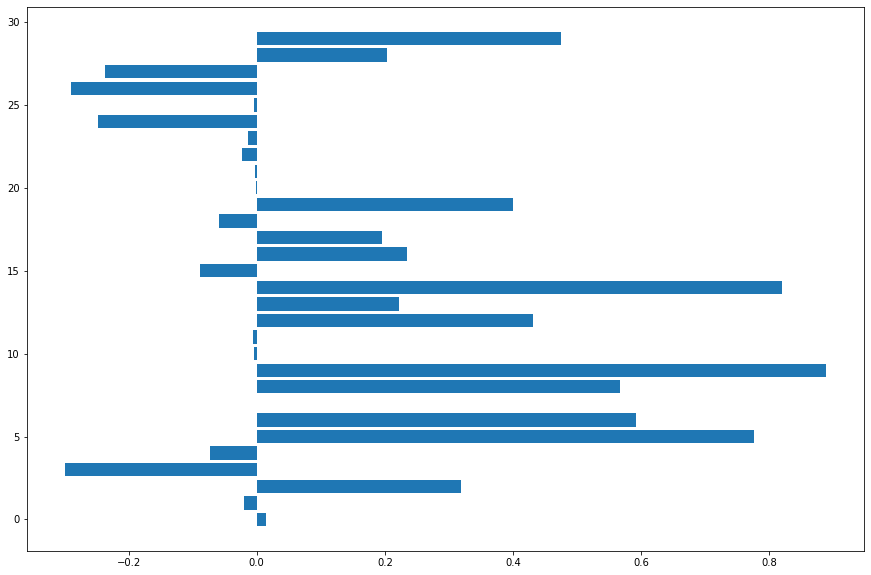

In [43]:
importance = model_logistic.coef_[0]   

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
fig, ax = plt.subplots(figsize=(15,10))
plt.barh([x for x in range(len(importance))], importance)
plt.show()  # корявая важность признаков

### Ridge

In [44]:
%%time

model_r = RidgeCV()
model_r.fit(features_train, target_train)
predictions_valid = model_r.predict(features_valid)
print('MAE  на валидационной выборке =', mae(target_valid, predictions_valid))
predictions_test = model_r.predict(features_test)
print('МАЕ на тестовой выборке =', mae(target_test, predictions_test))

MAE  на валидационной выборке = 6.092579356355167
МАЕ на тестовой выборке = 5.981540520744094
CPU times: user 43.3 ms, sys: 144 ms, total: 187 ms
Wall time: 151 ms


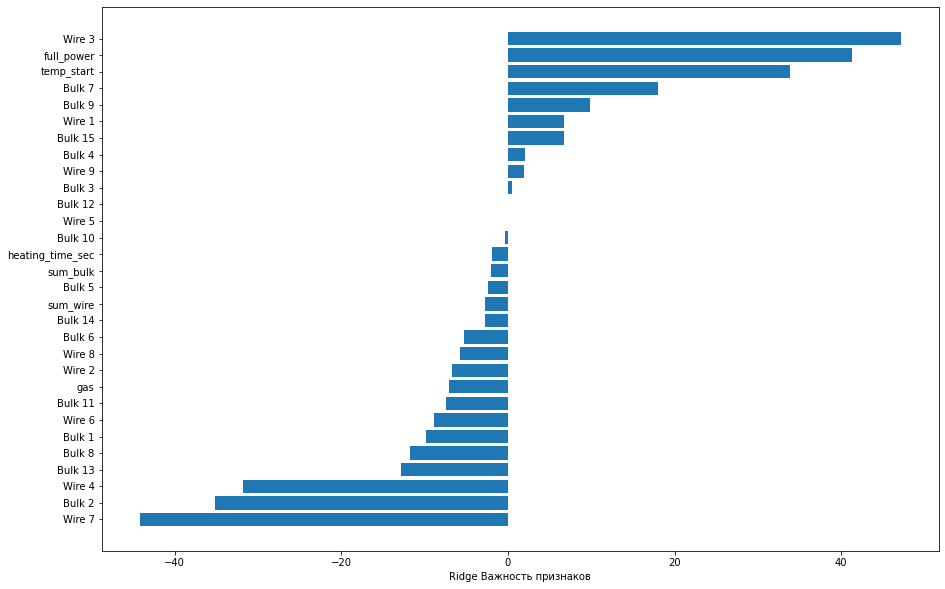

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model_r.coef_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model_r.coef_[sorted_idx])
plt.xlabel("Ridge Важность признаков");

### RandomForestRegressor

In [46]:
%%time
parametrs = {'n_estimators': [10, 50, 100], 
                 'max_depth': range (1,13, 2), 
                 'min_samples_split': range (1,8), 
                 'min_samples_split': range (2,10,2)
                }

grid_rfr = GridSearchCV(RandomForestRegressor(random_state=12345), 
                       parametrs, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rfr.fit(features_train, target_train)
params_rfr = grid_rfr.best_params_
rfr = RandomForestRegressor(**params_rfr, random_state=12345)
rfr.fit(features_train, target_train)
predictions_valid = rfr.predict(features_valid)
predictions_test = rfr.predict(features_test)
print(params_rfr)
print('МАЕ на валидационной выборке =', mae(target_valid, predictions_valid))
print('MAE на тестовой выборке =', mae(target_test, predictions_test))

{'max_depth': 11, 'min_samples_split': 4, 'n_estimators': 50}
МАЕ на валидационной выборке = 6.224827449604661
MAE на тестовой выборке = 5.965308425552921
CPU times: user 1min 9s, sys: 382 ms, total: 1min 9s
Wall time: 1min 10s


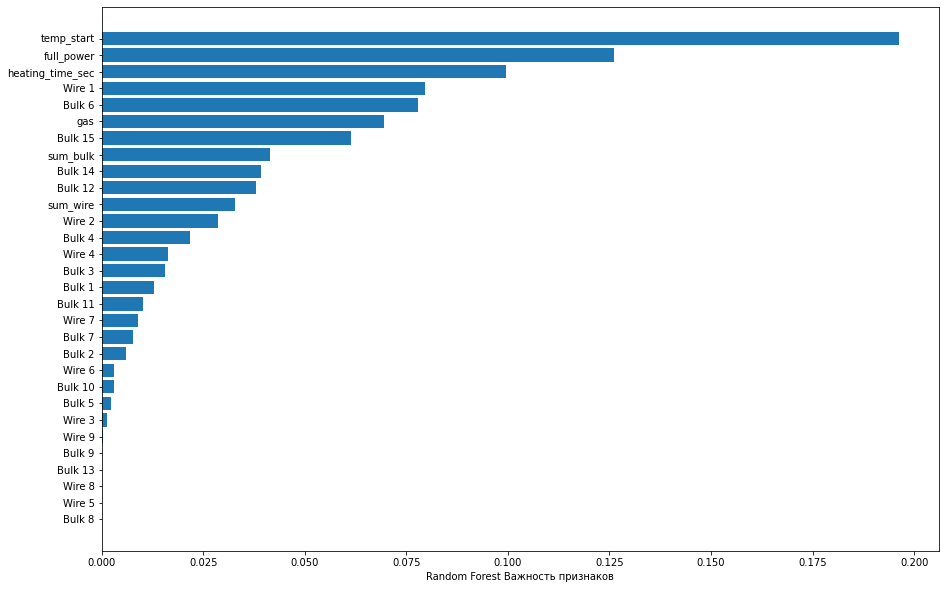

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = rfr.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Важность признаков");

### LGBMRegressor

In [48]:
%%time
parametrs = {'boosting_type' : ['gbdt'],
                  'n_estimators': [100], 
                  'learning_rate': [0.01, 0.03, 0.1],
                  'max_depth': range (1,13, 2),
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), 
                        parametrs, 
                        cv=5, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_lgbm.fit(features_train, target_train)
params_lgbm = grid_lgbm.best_params_
lgbm = LGBMRegressor(**params_lgbm)
lgbm.fit(features_train, target_train)
predictions_valid = lgbm.predict(features_valid)
predictions_test = lgbm.predict(features_test)
print(params_lgbm)
print('МАЕ на валидационной выборке =', mae(target_valid, predictions_valid))
print('MAE на тестовой выборке =', mae(target_test, predictions_test))

{'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
МАЕ на валидационной выборке = 6.00748251475959
MAE на тестовой выборке = 5.884701467531081
CPU times: user 48.1 s, sys: 449 ms, total: 48.5 s
Wall time: 49.1 s


Text(0.5, 0, 'LGBMRegressor Важность признаков')

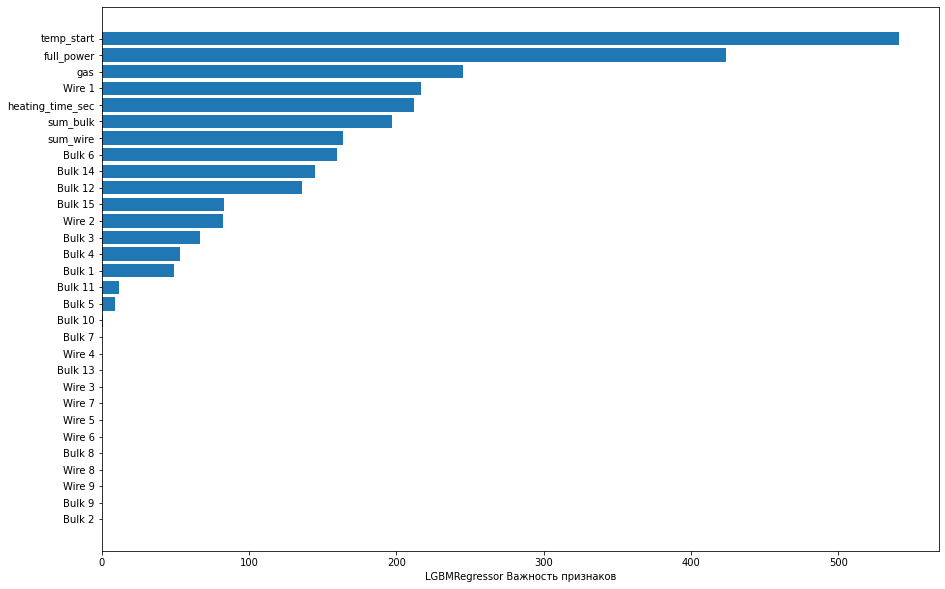

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = lgbm.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.xlabel("LGBMRegressor Важность признаков")

### XGBRegressor

In [50]:
%%time

model_xgb = XGBRegressor()
model_xgb.fit(features_train, target_train)
predictions_valid = model_xgb.predict(features_valid)
predictions_test = model_xgb.predict(features_test)
print('MAE на валидационной выборке:', mae(target_valid, predictions_valid))
print('MAE на тестовой выборке:', mae(target_test, predictions_test))

MAE на валидационной выборке: 6.374546282478932
MAE на тестовой выборке: 6.436678151334269
CPU times: user 3.35 s, sys: 4.48 ms, total: 3.35 s
Wall time: 3.33 s


Text(0.5, 0, 'XGBRegressor Важность признаков')

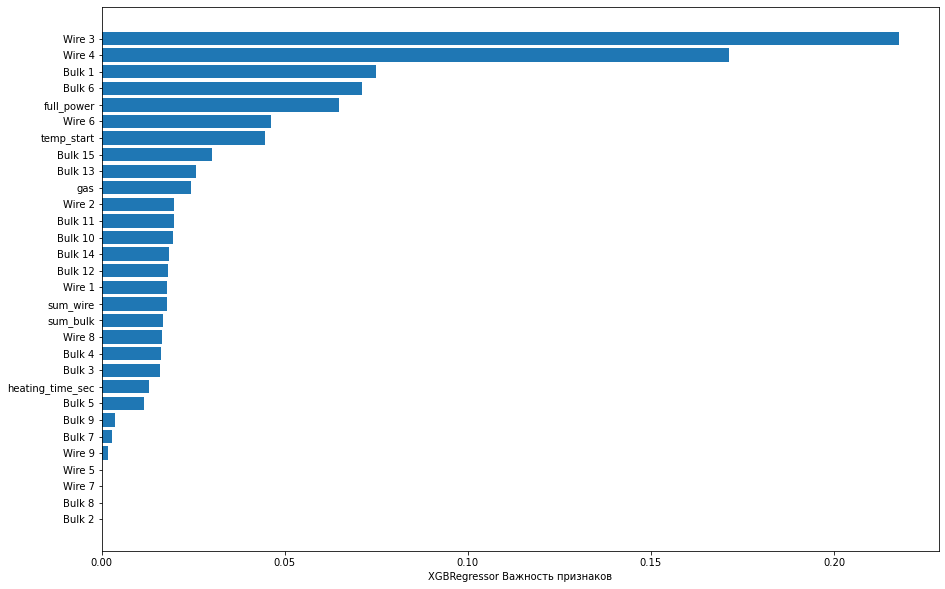

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBRegressor Важность признаков")

### CatBoost

In [52]:
%%time

parametrs = {'n_estimators': [100],
             'learning_rate': [0.03, 0.1],
             'max_depth': range (1,13, 2),
             'l2_leaf_reg': [8, 9]
            }
grid_cat = GridSearchCV(CatBoostRegressor(random_state=12345), 
                        parametrs, 
                        cv=5, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_cat.fit(features_train, target_train)
params_cat = grid_cat.best_params_
cat = CatBoostRegressor(**params_cat, verbose=False)
cat.fit(features_train, target_train)
predictions_valid = cat.predict(features_valid)
predictions_test = cat.predict(features_test)
print(params_cat)
print('МАЕ на валидационной выборке =', mae(target_valid, predictions_valid))
print('MAE на тестовой выборке =', mae(target_test, predictions_test))

0:	learn: 10.9219636	total: 46.4ms	remaining: 4.59s
1:	learn: 10.9005598	total: 46.9ms	remaining: 2.3s
2:	learn: 10.8834649	total: 47.3ms	remaining: 1.53s
3:	learn: 10.8790440	total: 47.7ms	remaining: 1.14s
4:	learn: 10.8587525	total: 48ms	remaining: 912ms
5:	learn: 10.8418064	total: 48.4ms	remaining: 758ms
6:	learn: 10.8240994	total: 48.7ms	remaining: 647ms
7:	learn: 10.8062129	total: 49.1ms	remaining: 564ms
8:	learn: 10.7833817	total: 49.4ms	remaining: 499ms
9:	learn: 10.7641255	total: 49.7ms	remaining: 448ms
10:	learn: 10.7465917	total: 50.1ms	remaining: 405ms
11:	learn: 10.7277937	total: 50.4ms	remaining: 369ms
12:	learn: 10.7073636	total: 50.8ms	remaining: 340ms
13:	learn: 10.6924734	total: 51.2ms	remaining: 314ms
14:	learn: 10.6752500	total: 51.5ms	remaining: 292ms
15:	learn: 10.6596386	total: 51.8ms	remaining: 272ms
16:	learn: 10.6423763	total: 52.2ms	remaining: 255ms
17:	learn: 10.6268160	total: 52.5ms	remaining: 239ms
18:	learn: 10.6064146	total: 52.8ms	remaining: 225ms
19:	le

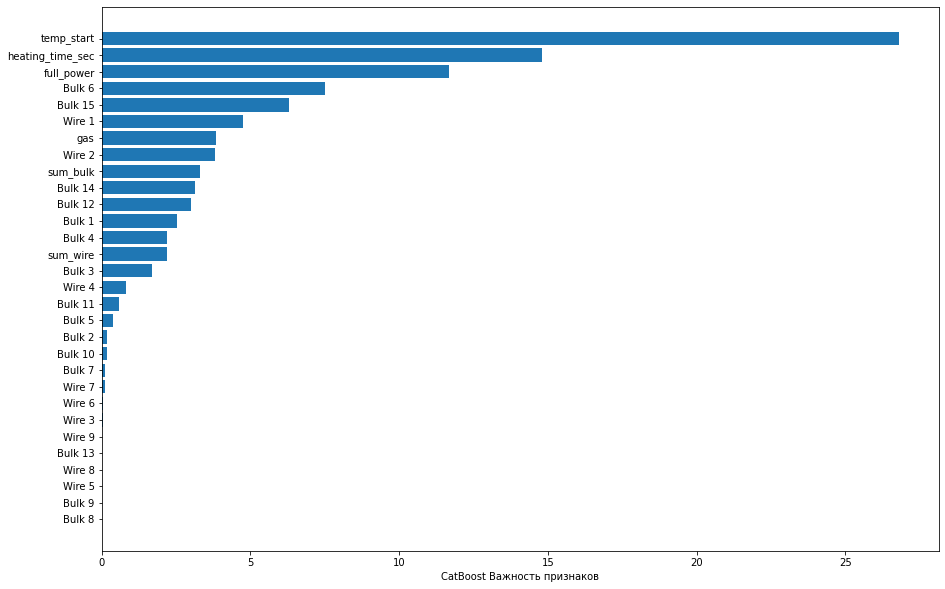

In [53]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = cat.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], cat.feature_importances_[sorted_idx])
plt.xlabel("CatBoost Важность признаков");

### Сравнение моделей

In [54]:
compare = pd.DataFrame()
compare['Модель'] = ['LinearRegression', 'LogisticRegression', 'Ridge', 'RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor', 'CatBoost']
compare['Время обучения'] = ['288 ms', '8.72 s', '791 ms', '1min 32s', '1h 38min 11s', '14.7 s', '2min 59s']
compare['МАЕ на валидационной выборке'] = [6.105, 7.602, 6.092, 6.224, 6.007, 6.374, 6.216]
compare['МАЕ на тестовой выборке'] = [5.992, 7.274, 5.981, 5.965, 5.884, 6.436, 5.881]
display(compare.sort_values(by=['МАЕ на тестовой выборке']))

,Модель,Время обучения,МАЕ на валидационной выборке,МАЕ на тестовой выборке
6,CatBoost,2min 59s,6.216,5.881
4,LGBMRegressor,1h 38min 11s,6.007,5.884
3,RandomForestRegressor,1min 32s,6.224,5.965
2,Ridge,791 ms,6.092,5.981
0,LinearRegression,288 ms,6.105,5.992
5,XGBRegressor,14.7 s,6.374,6.436
1,LogisticRegression,8.72 s,7.602,7.274


## Вывод

На валидационных данных лучше всего отработали модели LGBMRegressor, Ridge и LinearRegression, тогда как первая значительно уступает по времени. На тестовой выборке - CatBoost, LGBMRegressor и RandomForestRegressor.  
Хуже всего себя повела модель логистической регрессии с показателем МАЕ = 7.602 на валидационной выборке и 7.274 - на тестовой.

Если делать упор на точность, то стоит применять CatBoost с точностью на тестовой выборке 5.881, если на время - Ridge (метрика незначительно хуже даже без подбора гиперпараметров, зато алгоритм быстро обрабатывает большие объёмы данных.